# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

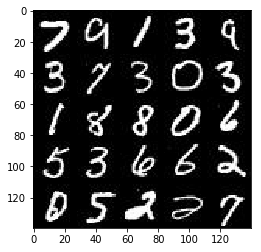

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

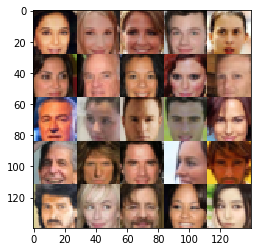

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 1, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='SAME')
    
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = image_channels
    
    steps = 0
    
    print(z_dim)
    input_real, input_z, lrate = model_inputs(image_width,image_height,image_channels,z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))               
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                if steps %10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps%100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

100
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 1.5484
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 3.9051
Epoch 1/2... Discriminator Loss: 1.7906... Generator Loss: 1.5890
Epoch 1/2... Discriminator Loss: 2.0935... Generator Loss: 3.2379
Epoch 1/2... Discriminator Loss: 2.0822... Generator Loss: 0.4177
Epoch 1/2... Discriminator Loss: 1.8781... Generator Loss: 0.4241
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 1.6411... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 1.2143


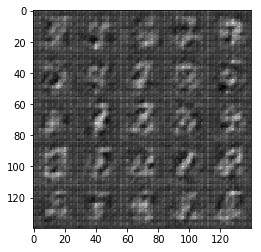

Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 1.8234... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 1.2626
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.9569
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.6893
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 1.6083
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 1.3561


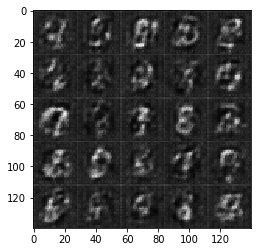

Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.8747
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.3456
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 2.2771
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 2.8148
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 2.2982
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 1.9764
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 0.9472


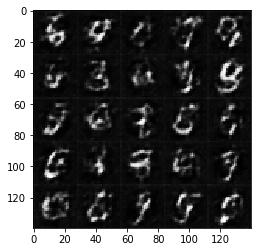

Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 1.8973
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 0.8092... Generator Loss: 1.2899
Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 1.7749
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 2.2481
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 1.5810
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 0.9482
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.6217
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 0.7639


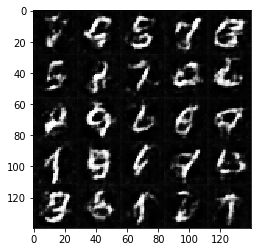

Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.1348
Epoch 1/2... Discriminator Loss: 1.7544... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 1.7360... Generator Loss: 0.4717
Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 1.7508... Generator Loss: 0.4945
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.6408
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.5157


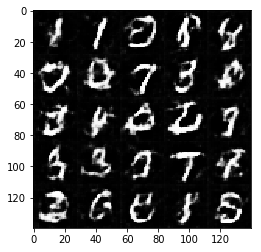

Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 1.7066
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.7680
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 2.0241
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.6987
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 1.0594
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 0.9950


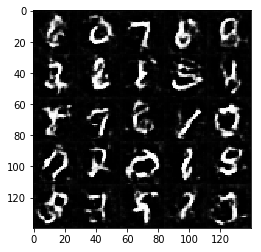

Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.4544
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 1.0232
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.5027
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.6409
Epoch 1/2... Discriminator Loss: 1.0149... Generator Loss: 0.7869


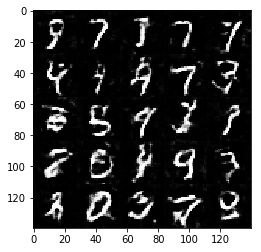

Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.5647
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.9318
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 1.1647
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 0.9289


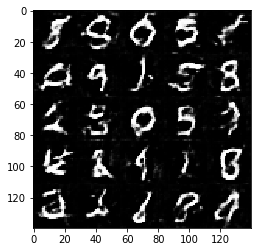

Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.0958
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.0744
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.9915
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 0.8904
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 2.5791... Generator Loss: 3.5738
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.7403


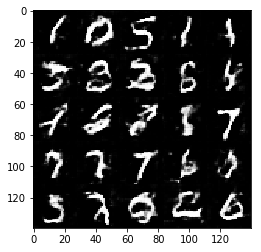

Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 1.8803
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 1.3515
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.5645
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 1.6596... Generator Loss: 0.4891
Epoch 1/2... Discriminator Loss: 1.8362... Generator Loss: 0.4503


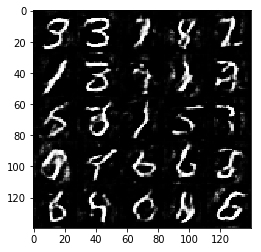

Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.2459
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 0.9317
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 1.1721
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 2.2070... Generator Loss: 0.4019


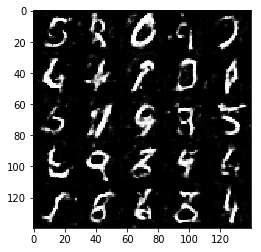

Epoch 1/2... Discriminator Loss: 2.9947... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 1.8559
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 0.9133
Epoch 1/2... Discriminator Loss: 0.8575... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 0.8179... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.7652


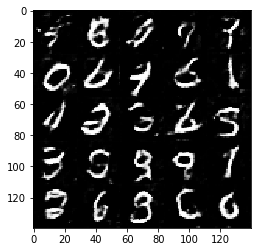

Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.5739
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.5965
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.5688
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.5683
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 1.2378
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 0.8696
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.6398... Generator Loss: 0.4916
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.4609


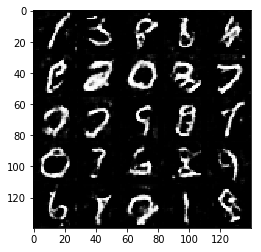

Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 0.8838... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.6512
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.5470
Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 1.6116
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 1.5797
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 1.0197
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.9493


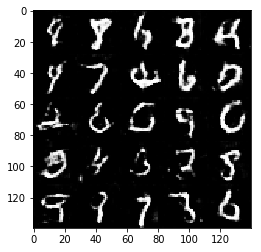

Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 1.2206
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 1.2832
Epoch 1/2... Discriminator Loss: 1.6617... Generator Loss: 0.5416
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 0.6665... Generator Loss: 1.4012
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.5109
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.8345


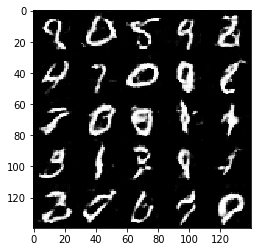

Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 1.3996
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.9811... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 0.8961
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.5535


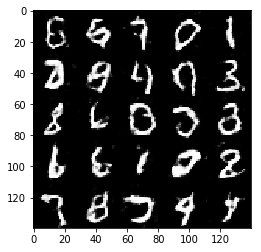

Epoch 1/2... Discriminator Loss: 1.6252... Generator Loss: 0.5592
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.2152
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 1.2311
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 1.9003
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.5352


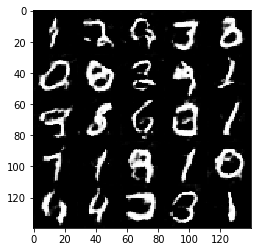

Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 1.9496... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.1000
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 2.2345... Generator Loss: 0.4222
Epoch 1/2... Discriminator Loss: 0.7263... Generator Loss: 1.3400
Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 2.0437... Generator Loss: 0.5138


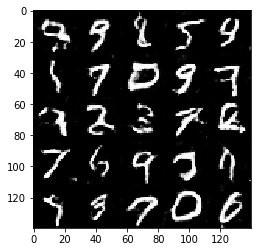

Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 1.1631
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 2.2647
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.2512
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.0292


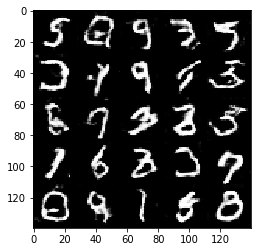

Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.4181
Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 1.5468
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.4752
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 2.0782
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 2.4523


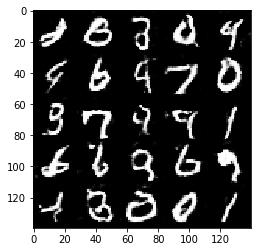

Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.0247
Epoch 2/2... Discriminator Loss: 0.7412... Generator Loss: 1.4231
Epoch 2/2... Discriminator Loss: 0.6768... Generator Loss: 1.5553
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 1.4654
Epoch 2/2... Discriminator Loss: 2.2809... Generator Loss: 0.4275
Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.6507
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.4176
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.6680
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.5993


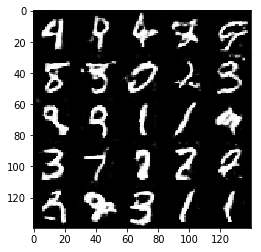

Epoch 2/2... Discriminator Loss: 0.7195... Generator Loss: 1.2943
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.7707
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 1.0114
Epoch 2/2... Discriminator Loss: 1.7754... Generator Loss: 0.5405
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.5490


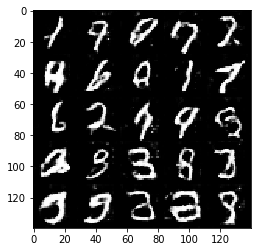

Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.3158
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.8432... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 0.9110
Epoch 2/2... Discriminator Loss: 0.6277... Generator Loss: 1.5151
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.7394
Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 1.9957
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.3237


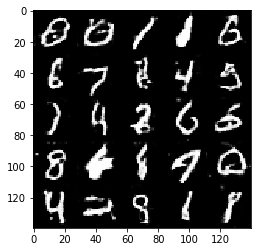

Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.4146
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 1.6657
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 2.6758
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.3419
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.0020
Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 1.2828
Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 1.7368


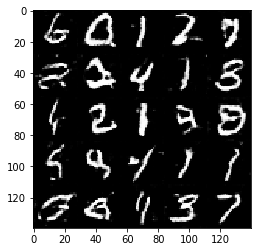

Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 2.4608
Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 1.4110
Epoch 2/2... Discriminator Loss: 1.6756... Generator Loss: 0.5141
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 1.1821
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.6482
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 2.3650
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.1248
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.6763


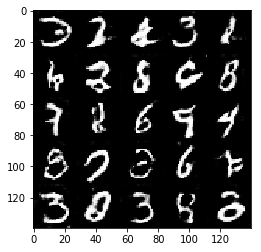

Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 2.4575... Generator Loss: 0.4472
Epoch 2/2... Discriminator Loss: 1.9009... Generator Loss: 0.4909
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.4993
Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 1.2715
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.2398
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.3990
Epoch 2/2... Discriminator Loss: 0.8416... Generator Loss: 1.0461


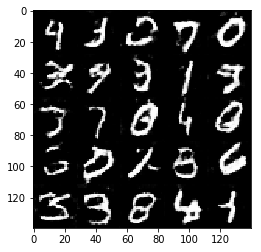

Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 1.9587
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 0.5822... Generator Loss: 1.7933
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.0984
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 1.7574... Generator Loss: 0.5028
Epoch 2/2... Discriminator Loss: 0.5923... Generator Loss: 1.7255
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.8940


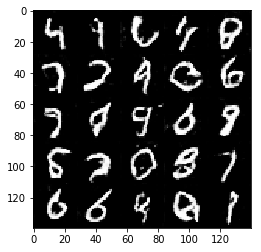

Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.6278
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.8044... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 1.1838
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.6351
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 2.4190
Epoch 2/2... Discriminator Loss: 1.9651... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 2.8015
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.9697
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 1.1178


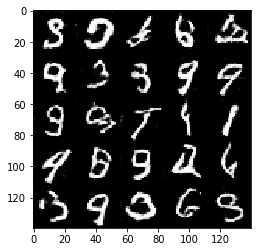

Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 1.6212
Epoch 2/2... Discriminator Loss: 0.6506... Generator Loss: 1.4800
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.6934
Epoch 2/2... Discriminator Loss: 0.6698... Generator Loss: 2.1146
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.0861
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 1.5167


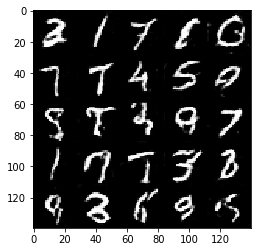

Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.4421
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 1.8082
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 3.0662
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 1.1730
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 0.6553... Generator Loss: 1.3667
Epoch 2/2... Discriminator Loss: 0.5564... Generator Loss: 1.9067


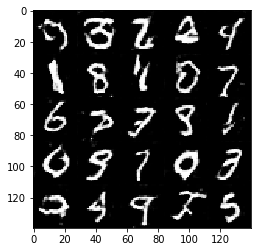

Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.9709
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.1253
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 3.9362
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.5796
Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 1.7975


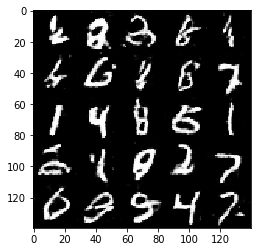

Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 1.4482... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 2.0533
Epoch 2/2... Discriminator Loss: 0.5291... Generator Loss: 2.2631
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 0.9702
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.8344... Generator Loss: 1.0417
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 1.7673
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.5877
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 1.0494


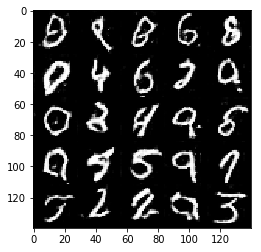

Epoch 2/2... Discriminator Loss: 1.5924... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 0.6382... Generator Loss: 2.2662
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 1.3058
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.5769
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 1.5308
Epoch 2/2... Discriminator Loss: 0.5381... Generator Loss: 1.9817
Epoch 2/2... Discriminator Loss: 0.6111... Generator Loss: 1.7964
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.4969
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.1683


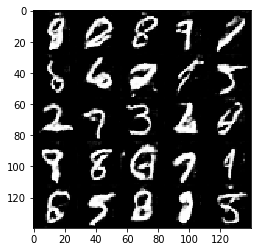

Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 0.5720
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.6607
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.0523
Epoch 2/2... Discriminator Loss: 1.5697... Generator Loss: 3.9267
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 2.2699
Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 1.2210
Epoch 2/2... Discriminator Loss: 0.7216... Generator Loss: 1.7510
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.1808
Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 1.1630
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.0015


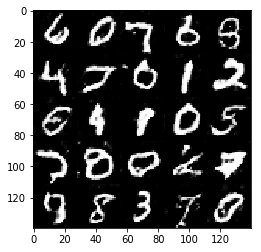

Epoch 2/2... Discriminator Loss: 0.6669... Generator Loss: 1.8778
Epoch 2/2... Discriminator Loss: 0.6013... Generator Loss: 1.6926
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 4.2546
Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.2956
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 0.6415... Generator Loss: 1.4678
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 2.1365... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 0.8572


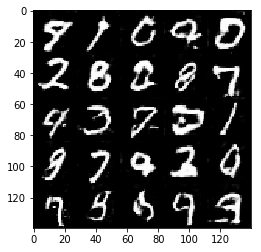

Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 1.3294
Epoch 2/2... Discriminator Loss: 1.4601... Generator Loss: 0.6634
Epoch 2/2... Discriminator Loss: 0.6546... Generator Loss: 1.4624
Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 1.2177
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.1071
Epoch 2/2... Discriminator Loss: 0.8561... Generator Loss: 1.0377
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.1758
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.3092


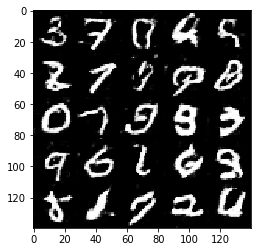

Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.5462
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 2.0162
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.3986
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.6797
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 1.5959
Epoch 2/2... Discriminator Loss: 1.5025... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 1.8121
Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 1.1269


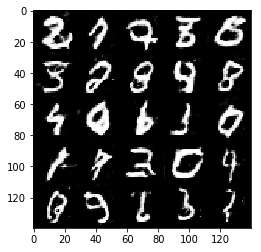

Epoch 2/2... Discriminator Loss: 0.6969... Generator Loss: 1.2515
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 1.7921... Generator Loss: 0.5448
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 3.7959
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 1.2990


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

100
Epoch 1/1... Discriminator Loss: 5.8870... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 2.2951... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.7414... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.8603
Epoch 1/1... Discriminator Loss: 2.4356... Generator Loss: 0.3906
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.6630


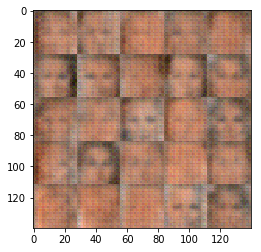

Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.8918... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 1.7865... Generator Loss: 2.5768
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.5073


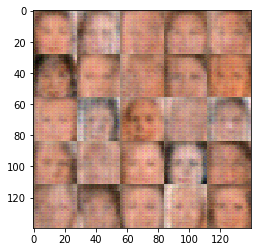

Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.8132... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.9724


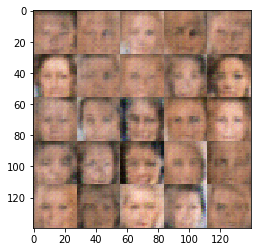

Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.6866


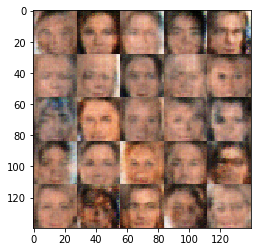

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9147


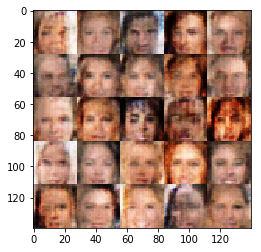

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.6981


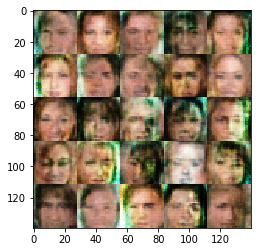

Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.5697


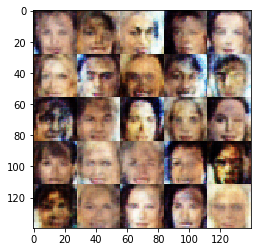

Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8866


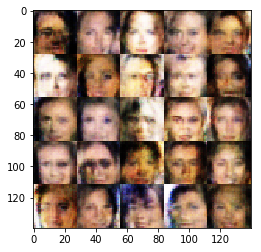

Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6368


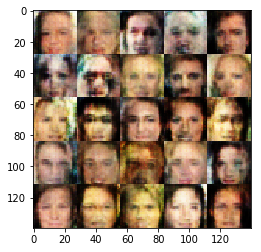

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6250


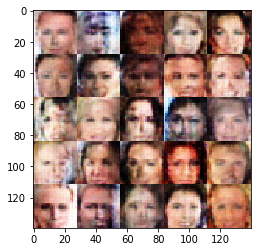

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7307


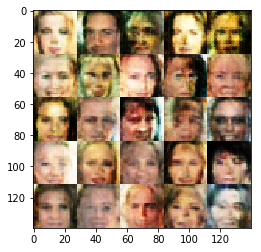

Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.9967


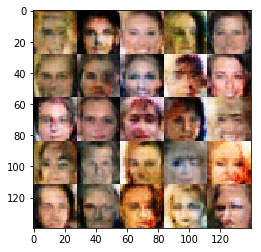

Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.7985... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6193


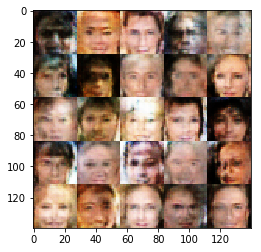

Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6522


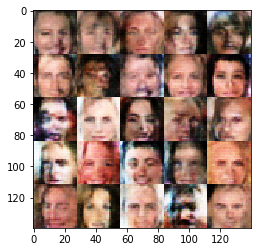

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.6672... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7309


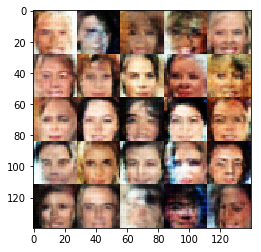

Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.9965


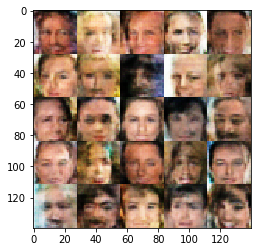

Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.4520


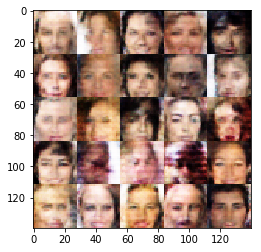

Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6283


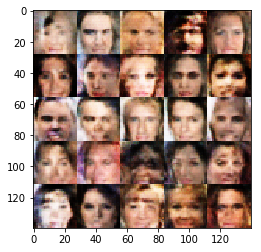

Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.6578


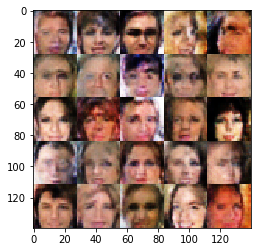

Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 1.0463


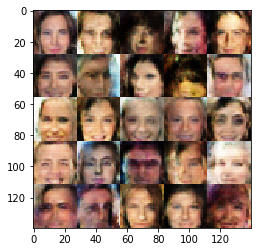

Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.7621


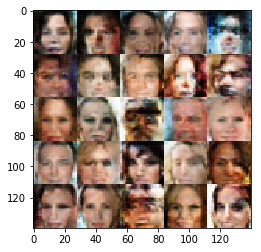

Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.0451


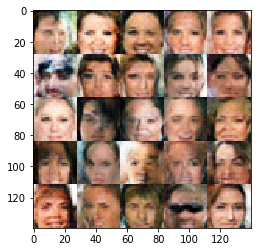

Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.9943


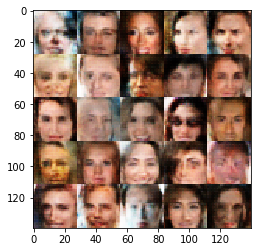

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.2440


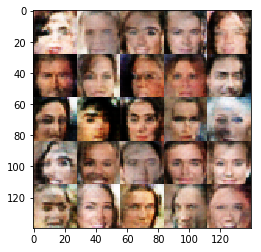

Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.9926


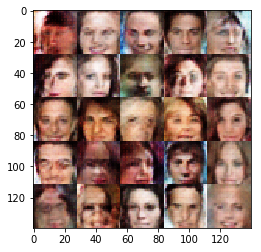

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.6756... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.5256


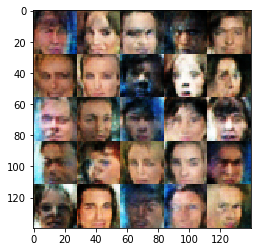

Epoch 1/1... Discriminator Loss: 1.7232... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.7963


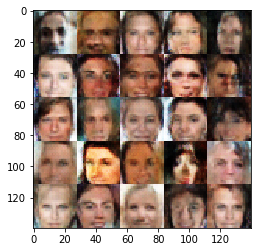

Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.4561


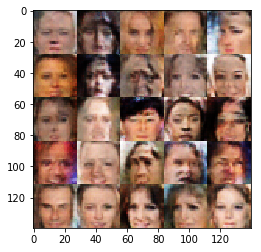

Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.6631... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.0514


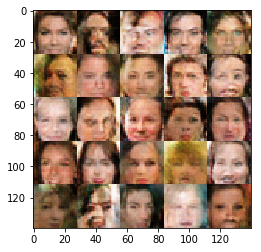

Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.9304... Generator Loss: 0.4167


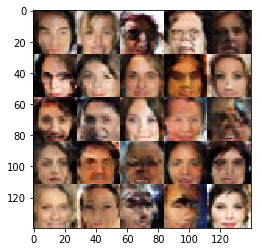

Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.8865... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5196


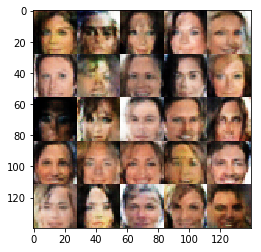

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 1.5217
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.6915... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.1697
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8054


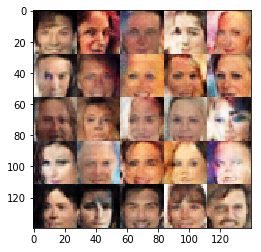

Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6194


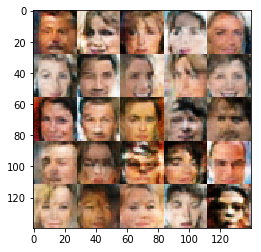

Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6462


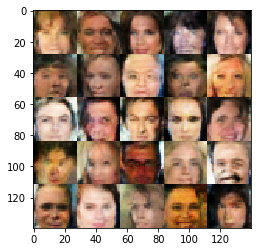

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9237


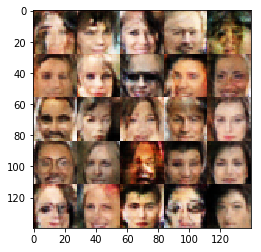

Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6675


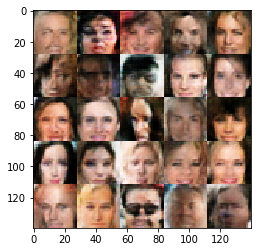

Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 2.0689... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.5711


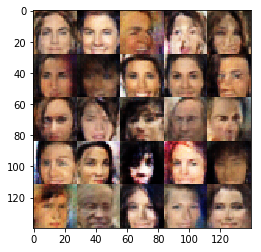

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.7079


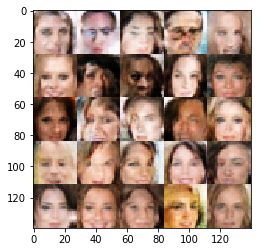

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6873


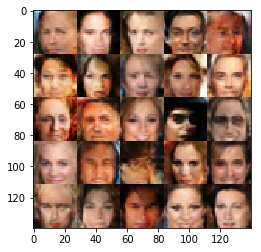

Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8636


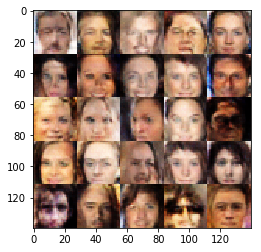

Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.0252


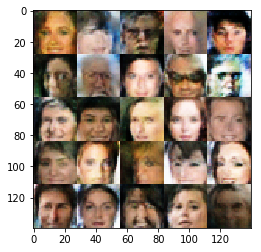

Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 1.6274
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.9029


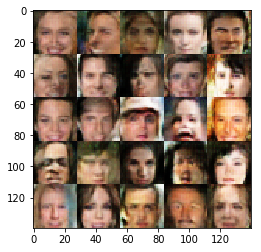

Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.3108


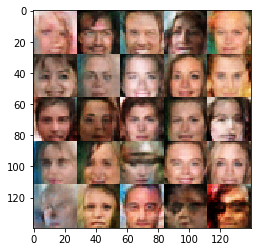

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.3317
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6116


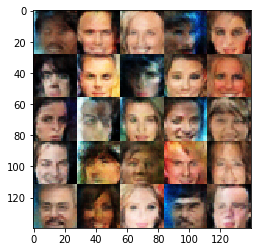

Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.4657


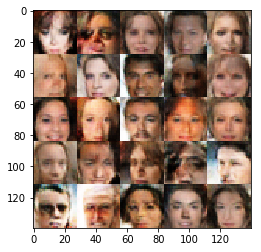

Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 2.2829... Generator Loss: 0.3669
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6217


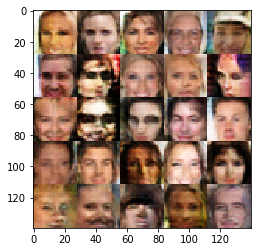

Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.4435
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.4751


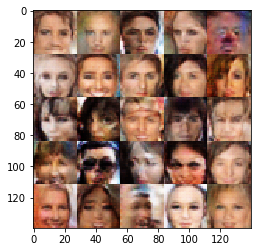

Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.0730


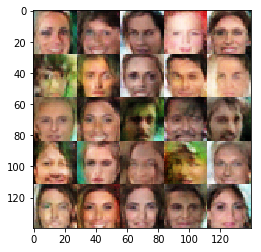

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8878


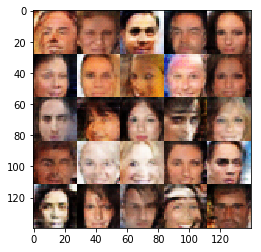

Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5240


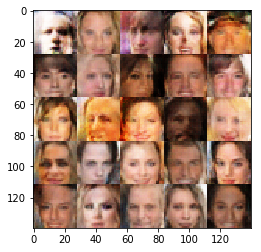

Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.9140


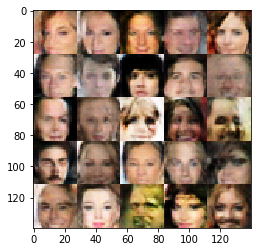

Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.3489


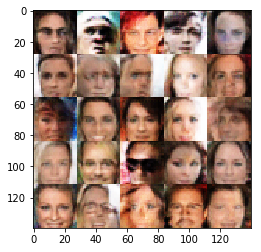

Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.5594


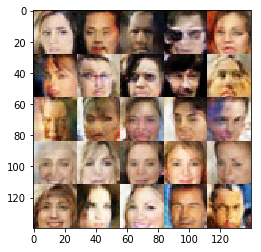

Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5792


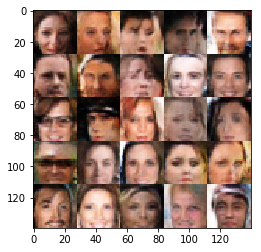

Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.7419


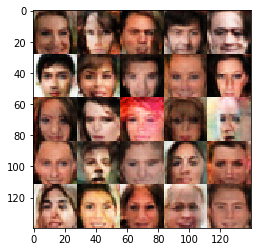

Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7714


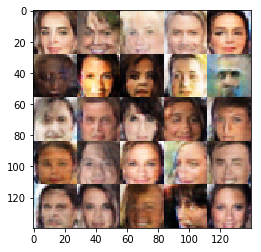

Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.9483


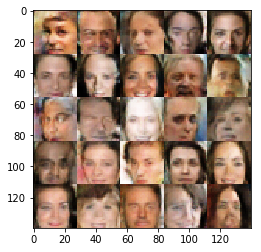

Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.6852... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6674


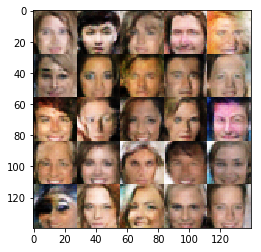

Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.5022


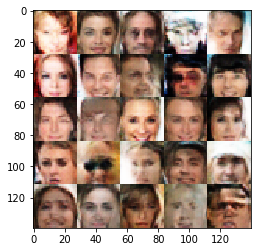

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9315


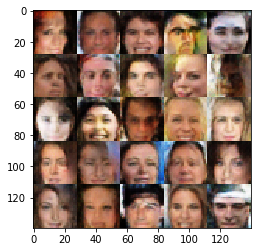

Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.6735


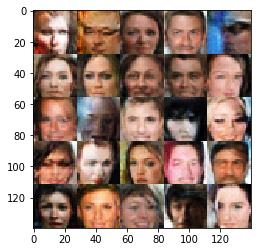

Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.9269... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6699


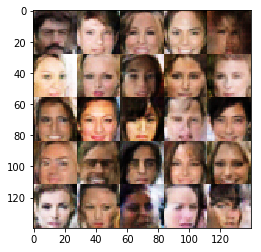

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.5627


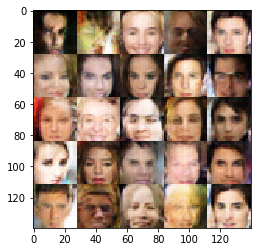

Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.1694


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.